### A/B тестирование нового алгоритма рекомендаций в приложении ###

Команда ML, сделала новые алгоритмы рекомендаций новостей в ленте:
1) Показываем пользователю посты, наиболее похожие на те, которые он лайкал.
2) Показываем пользователю посты, которые лайкали похожие на него пользователи.

Обновления выкатили на пользователей из группы 2, с 21 по 27.11.25, контрольная группа - 1. 

Предполагаем, что после обновления алгоритмов пользователям будет больше нравится контент, поэтому в качестве целевой метрики взят **CTR** из просмотров в лайки. 

H<sub>0</sub>: СTR в группе 1 и 2 не будут статистически отличаться    
H<sub>1</sub>: CTR в экспериментальной группе 2 будет выше и это различие будет статистически значимо



In [13]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
#подключение к бд
from dotenv import load_dotenv
import os
import clickhouse_connect

In [22]:
load_dotenv(override=True)

True

In [23]:
connection = clickhouse_connect.get_client(
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    username=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_DATABASE")
)


DatabaseError: Received ClickHouse exception, code: 516, server response: Code: 516. DB::Exception: student: Authentication failed: password is incorrect, or there is no user with such name. (AUTHENTICATION_FAILED) (version 25.6.9.98 (official build)) (for url http://clickhouse.lab.karpov.courses:8123)

In [49]:
query="""
SELECT 
    user_id, 
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as CTR
FROM simulator_20251220.feed_actions
WHERE toDate(time) BETWEEN '2025-11-21' AND '2025-11-27' AND exp_group in (1,2)
GROUP BY user_id, exp_group
"""

In [50]:
df=ph.read_clickhouse(query, connection= connection)
df

,user_id,exp_group,likes,views,CTR
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,39,141,0.276596
4,18392,1,7,32,0.218750
...,...,...,...,...,...
19892,17146,2,0,10,0.000000
19893,30872,1,11,59,0.186441
19894,25383,2,42,127,0.330709
19895,139020,2,17,41,0.414634


In [51]:
df.groupby('exp_group')['user_id'].nunique()

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

В обеих группах примерно одинаковое количество пользователей

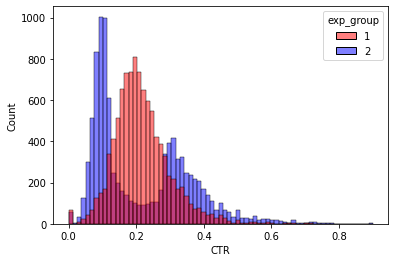

In [52]:
groups=sns.histplot(data= df,
                    x='CTR', 
                    hue= 'exp_group',
                    alpha= 0.5,
                    kde=False, 
                    palette=['r','b'])

Распределение СTR  в группе 2 - двугорбое, смещено влево и имеет правосторонний хвост. 

Несмотря на то что распределение CTR сильно смещено влево, попробуем использовать ***t-test*** для сравнения средних так как соблюдаются условия:    
- Большой размер выборки (Центральная Предельная Теорема):
T-тест проверяет равенство средних значений выборок, а не нормальность исходных данных.
Согласно Центральной Предельной Теореме (ЦПТ), распределение выборочных средних стремится к нормальному при достаточно большом объеме выборки (в нашем случае в каждой группе около 10000 значений), независимо от формы исходного распределения.
- У нас достаточно много наблюдений (около 10000 в каждой группе), следовательно выборочная оценка дисперсии часто будет сходиться (aka будет очень похожа на истинную дисперсию распределения). 



In [53]:
results_ttest = stats.ttest_ind(df[df.exp_group == 1].CTR,
                df[df.exp_group == 2].CTR,
                equal_var=False)
print(f"t-статистика = {results_ttest.statistic}")
print(f"p-value = {results_ttest.pvalue}")


t-статистика = 0.4051491913112757
p-value = 0.685373331140751


In [54]:
if results_ttest.pvalue < 0.05:
    print('В экспериментальной группе 2 CTR статистически значимо различается от группы 1')
else:
    print('CTR в экспериментальной и контрольной группе не различаются статистически')

CTR в экспериментальной и контрольной группе не различаются статистически


Но учитывая, что   
- Распределение очень сильно скошено.
- В распределении много выбросов.
- В распределении очень высока вероятность больших по модулю отклонений (жирные выбросы — часть распределения).
Т-тест вероятно на этих данных не обладает большой мощностью

**Проверим статистики тестом Манна-Уитни**

Поскольку тест Манна-Уитни сравнивает ранги (вероятность того, что случайное значение из одной группы будет больше, чем из другой),  не требует нормальности распределения, не чувствителен к выбросам, его результат будет более мощным для наших выборок, учитывая распределение CTR  в экспериментальной группе 2.

In [55]:
results_mw=stats.mannwhitneyu(df[df.exp_group == 1].CTR, 
                   df[df.exp_group == 2].CTR,
                   alternative = 'two-sided')
print(f'U-статистика = {results_mw.statistic}')
print(f'pvalue = {results_mw.pvalue}')

U-статистика = 55189913.0
pvalue = 4.632205841806026e-45


In [56]:
if results_mw.pvalue < 0.05:
    print('По тесту Манна-Уитни в экспериментальной группе 2 CTR статистически значимо различается от группы 1')
else:
    print('По тесту Манна-Уитни CTR в экспериментальной и контрольной группе не различаются статистически')

По тесту Манна-Уитни в экспериментальной группе 2 CTR статистически значимо различается от группы 1


**Проведем t-test на сглаженном CTR** 


In [57]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

<Axes: xlabel='smothed_ctr', ylabel='Count'>

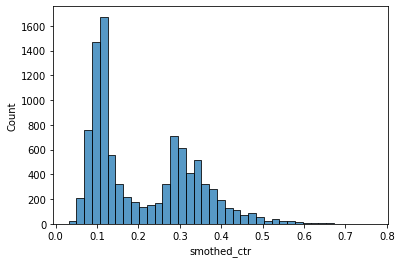

In [58]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis = 1)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
#Визуализируем сглаженный CTR для второй группы
sns.histplot(group2.smothed_ctr, 
             kde = False)

Распределение CTR в группе 2 по-прежнему двугорбое и смещено влево, с правосторонним хвостом и выбросами, поэтому т-тест в данном случае будет обладать малой мощностью и может не дать правильных результатов.

In [59]:
results_ttest_smoothed = stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)
print(f"t-статистика = {results_ttest_smoothed.statistic}")
print(f"p-value = {results_ttest_smoothed.pvalue}")

t-статистика = 1.9460491517027683
p-value = 0.05166679015318526


In [60]:
if results_ttest_smoothed.pvalue < 0.05:
    print('В экспериментальной группе 2 CTR статистически значимо различается от группы 1')
else:
    print('CTR в экспериментальной и контрольной группе не различаются статистически')

CTR в экспериментальной и контрольной группе не различаются статистически


При проведении т-теста на сглаженном CTR p-value стремится к 0.05, но все-таки больше. 

**Применим Пуассоновский бутстреп**

 Cравним общегрупповой CTR в группах A и B 

<Axes: ylabel='Count'>

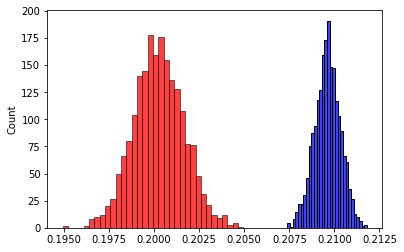

In [61]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2



likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color = 'blue')
sns.histplot(ctr2, color = 'red')

Распределения глобальных CTR1 и глобальных СTR 2 не пересекаются, значит разница между группами практически наверняка значима. Группа 2 находится левее, следовательно метрика Global CTR в ней ниже.

<Axes: ylabel='Count'>

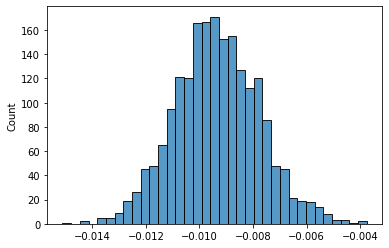

In [62]:
#Распределение разницы между глобальными CTR
diff =ctr2 - ctr1
sns.histplot(diff)

Вся гистограмма находится левее нуля (все значения разницы отрицательные).  
Это говорит о том, что практически в каждой из 2000 симуляций Global CTR группы 2 был ниже (или имел меньшее значение), чем Global CTR группы 1. Разница между группами статистически значима и не случайна.

In [63]:
# Рассчитаем верхнюю и нижнюю границы 95% доверительного интервала
lower_bound = np.percentile(diff, 2.5)
upper_bound = np.percentile(diff, 97.5)

print(f"95% Доверительный интервал для разницы CTR: [{lower_bound:.4f}, {upper_bound:.4f}]")


95% Доверительный интервал для разницы CTR: [-0.0124, -0.0061]


Доверительный интервал не содержит 0, обе границы отрицательные. Что подтверждает, глобальный CTR группы 2 статистически значимо ниже, чем в группе 1.

***Попробуем еще один метод - бакетное преобразование***

In [64]:
query2 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.5)(ctr) as median_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20251220.feed_actions 
    WHERE toDate(time) between '2025-11-21' and '2025-11-27'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df2=ph.read_clickhouse(query2, connection=connection)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

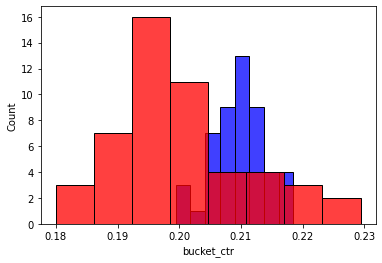

In [65]:
sns.histplot(df2[df2.exp_group == 1].bucket_ctr, color = 'blue')
sns.histplot(df2[df2.exp_group == 2].bucket_ctr, color = 'red')

Распределение бакетного CTR даже более-менее похоже на нормальное, но в тестовой группе смещено влево и имеет правосторонний хвост.

In [66]:
bucket_ttest_result=stats.ttest_ind(df2[df2['exp_group']==1]['bucket_ctr'],
                                  df2[df2['exp_group']==2]['bucket_ctr'],
                                  equal_var=False)
print(f"t-статистика = {bucket_ttest_result.statistic}")
print(f"p-value = {bucket_ttest_result.pvalue}")

t-статистика = 5.614819358149381
p-value = 4.592644937473873e-07


In [67]:
if bucket_ttest_result.pvalue < 0.05:
    print('В экспериментальной группе 2 бакетный CTR статистически значимо различается от группы 1')
else:
    print('Бакетный CTR в экспериментальной и контрольной группе не различаются статистически')

В экспериментальной группе 2 бакетный CTR статистически значимо различается от группы 1


Применим к бакетному CTR тест Манна-Уитни, но так как на графике распределений бакетных CTR первая (контрольная группа) расположена левее, проверим, что CTR в группе 2 (тестовой) - меньше, чем в группе 1. 

In [68]:
bucket_mw_result=stats.mannwhitneyu(df2[df2['exp_group']==2]['bucket_ctr'],
                                  df2[df2['exp_group']==1]['bucket_ctr'],
                                   alternative='less'
                                  )
print(f"U-статистика = {bucket_mw_result.statistic}")
print(f"p-value = {bucket_mw_result.pvalue}")

U-статистика = 503.0
p-value = 1.3288213902005047e-07


In [69]:
if bucket_mw_result.pvalue < 0.05:
    print('По тесту Манна-Уитни в экспериментальной группе 2 бакетный CTR статистически значимо меньше, чем в группе 1')
else:
    print('По тесту Манна-Уитни CTR в экспериментальной и контрольной группе не различаются статистически')

По тесту Манна-Уитни в экспериментальной группе 2 бакетный CTR статистически значимо меньше, чем в группе 1


### Общий вывод:

По тесту Манна-Уитни, есть статистическая разница между CTR группы 1 (контроль) и группы 2 (тест).  

При применении Пуассоновского бустрепа, выяснилось, что распределение разницы между глобальными CTR 2 группы и CTR 1 группы меньше 0, доверительный интервал не содержит 0, обе границы отрицательные. Это говорит, что глобальный CTR группы 2 статистически значимо ниже, чем в группе 1.

При применении т-теста и теста Манн-Уитни над бакетным преобразованием, так же получили статистическое подтверждение различия в двух группах.

Учитывая снижение CTR в тестовой группе, не рекомендуется раскатывать новый алгортм рекомендаций на других пользователей.

#### Почему такое могло произойти? ####
##### *1. Технические ошибки:* #####   
Время эксперимента: если алгоритм рекомендаций выкатили не с началом тестирования, а в какой-то промежуток времени с 21 по 27 ноября 2025 года.
##### *2. Алгоритм, который показывает только похожий контент, может быстро привести к ситуации, когда пользователю становится скучно или нечего лайкать после просмотра первых релевантных постов.* #####   
Результат: CTR снижается из-за однообразия рекомендаций.
##### *3. Некачественная реализация коллаборативной фильтрации (Алгоритм 2)* #####   
Если модель неверно определила схожесть пользователей, она может рекомендовать нерелевантный контент. Например, пользователю, который обычно читает новости политики, начинают активно показывать кулинарные рецепты, которые он никогда не лайкал.   
Результат: Рекомендации становятся менее точными, CTR падает.
##### *4. Изменения в алгоритмах могли непреднамеренно увеличить общее количество просмотров (views) без пропорционального увеличения лайков (likes)* #####

